In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 
bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-prod')

### Data Retrieval

In [3]:
REFRESH=True

In [4]:
if REFRESH:
    
    sql = '''
        DECLARE latest_date DATE;
        SET latest_date = (
            SELECT MAX(offer_start_date) 
            FROM `gcp-wow-rwds-ai-data-prod.loyalty_car_analytics.fact_campaign_sales_solus_view` fcs
            WHERE campaign_code IN (
                SELECT DISTINCT campaign_code || '-' || campaign_type
                FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER`
            )
        );
        
        CREATE OR REPLACE TABLE `gcp-wow-rwds-ai-mmm-prod.dhioe.MMM_FORECASTING_CAT_DEV` AS
        WITH dates_campaign AS (
            SELECT * 
            FROM (
                SELECT DISTINCT fw_start_date + 1 AS fw_start_date
                FROM `wx-bq-poc.loyalty.dim_date`
                WHERE fw_start_date >= '2021-04-20'
                    AND fw_start_date <= latest_date
            )
                CROSS JOIN (
                    SELECT DISTINCT 
                        Campaign_Seg_Grp_Id
                    FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER`
                    WHERE Campaign_Seg_Grp_Id != 'None'
                )
            GROUP BY 1,2
        ),

        promo AS (
            SELECT 
                crn,
                campaign_code,
                campaign_start_date,
                offer_start_date,
                0 AS post_week_flag,
                CASE WHEN redeem_flag IS NOT NULL THEN 1 ELSE 0 END AS redeem_flag,
                attributed_inc_sales AS inc_sales,
                reward_val
            FROM
                `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales_solus` 
            WHERE offer_start_date >= '2021-04-20'
                AND offer_start_date <= latest_date
        ),

        post AS (
            SELECT  
                crn,
                campaign_code,
                campaign_start_date,
                fw_start_date + 1,
                1 AS post_week_flag,
                0 AS redeem_flag,
                inc_sales,
                0 AS reward_val
            FROM 
                `wx-bq-poc.loyalty_bi_analytics.cp_att_crn_halo_post_all`
            WHERE fw_start_date >= '2021-04-20'
                AND fw_start_date <= latest_date
        ),

        promo_post AS (
            SELECT * FROM promo 
            UNION ALL
            SELECT * FROM post
        ), 

        master AS (
            SELECT 
                pp.offer_start_date,
                post_week_flag,
                ma.Campaign_Seg_Grp_Id,
                COUNT(DISTINCT pp.crn) AS audience,
                SUM(inc_sales) AS inc_sales,
                SUM(redeem_flag) AS redeemers,
                SUM(reward_val) AS reward_val
            FROM promo_post pp
                JOIN `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER` ma
                    ON pp.crn = ma.crn
                    AND pp.campaign_code = ma.campaign_code || '-' || ma.campaign_type
                    AND pp.campaign_start_date = DATE(ma.campaign_start_date)
            WHERE ma.Campaign_Seg_Grp_Id != 'None'
            GROUP BY 1,2,3
        )

        SELECT 
            dc.fw_start_date AS ds,
            dc.Campaign_Seg_Grp_Id AS offer_type,
            SUM(audience) AS promo_post_audience,
            SUM(audience) - SUM(CASE WHEN post_week_flag = 1 THEN audience ELSE 0 END) AS promo_audience,
            SUM(inc_sales) AS inc_sales,
            SUM(redeemers) AS redeemers,
            SUM(reward_val) AS cost
        FROM dates_campaign dc
            LEFT JOIN master ma
                ON dc.fw_start_date = ma.offer_start_date
                AND dc.Campaign_Seg_Grp_Id = ma.Campaign_Seg_Grp_Id
        GROUP BY 1, 2
        ORDER BY 1, 2;
    '''

    response = bq.query(sql).result()

In [6]:
sql = '''
    SELECT *
    FROM `gcp-wow-rwds-ai-mmm-prod.dhioe.MMM_FORECASTING_CAT_DEV`
'''

data = bq.query(sql).result().to_dataframe()

data['inc_sales'] = data['inc_sales'].astype(float)
data['redeemers'] = data['redeemers'].astype(float)
data['cost'] = data['cost'].astype(float)
data['promo_post_audience'] = data['promo_post_audience'].astype(float)
data['promo_audience'] = data['promo_audience'].astype(float)

data['rpc'] = data['inc_sales'] / data['promo_post_audience']
data['rdm'] = data['redeemers'] / data['promo_audience']
data['cpc'] = data['cost'] / data['promo_audience']

data = data[data['offer_type'] != 'None']

### Input Parameters

In [7]:
OFFER_TYPE = 'SG-005'
METRIC = 'rpc'

if METRIC in ['rdm', 'cpc']:
    SCALE = 'promo_audience'
else:
    SCALE = 'promo_post_audience'
    
WINDOW = 6

In [8]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [9]:
def prophet_impute(df):        
    
    def _prophet_impute(row):
        if np.isnan(row['y']):
            return row['yhat']
        else:
            return row['y']
    
    # use prophet to interpolate
    m = Prophet()
    m.add_seasonality(name='2-week', period=14, fourier_order=2)
    
    with suppress_stdout_stderr():
        m.fit(df)

    future = m.make_future_dataframe(periods=0, freq='w')
    forecast = m.predict(future)
    
    if OFFER_TYPE == 'TMP':
        forecast['yhat'] = forecast['2-week']
    
    forecast = forecast[['ds', 'yhat']]
    forecast['ds'] = forecast['ds'].apply(lambda x: x.date())
    
    df = df.merge(forecast, how='inner', left_on='ds', right_on='ds')
    df['y'] = df.apply(_prophet_impute, axis=1)
    
    return df[['ds', 'scale', 'y']]
    
    
def negative_impute(df):
    # replace negative value with zero for positive metrics
    if METRIC in ['rdm', 'cpc']:
        df['y'] = df['y'].apply(lambda x: 0 if x < 0 else x) 
    
    return df[['ds', 'scale', 'y']]

In [10]:
OFFER_TYPES = data['offer_type'].unique()

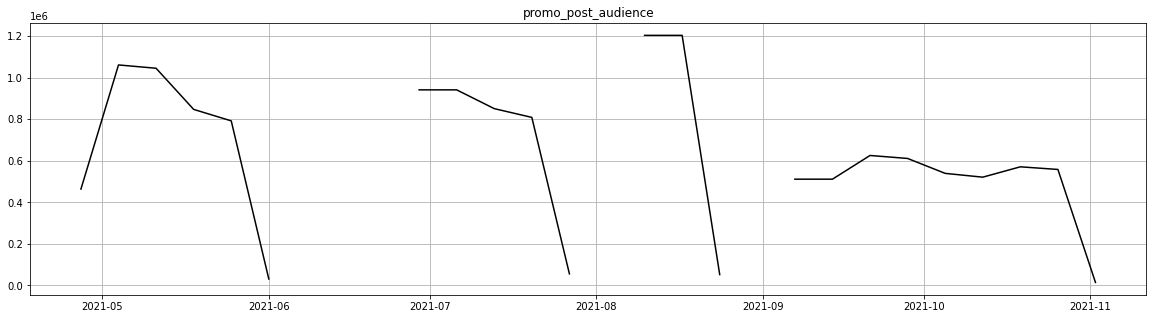

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


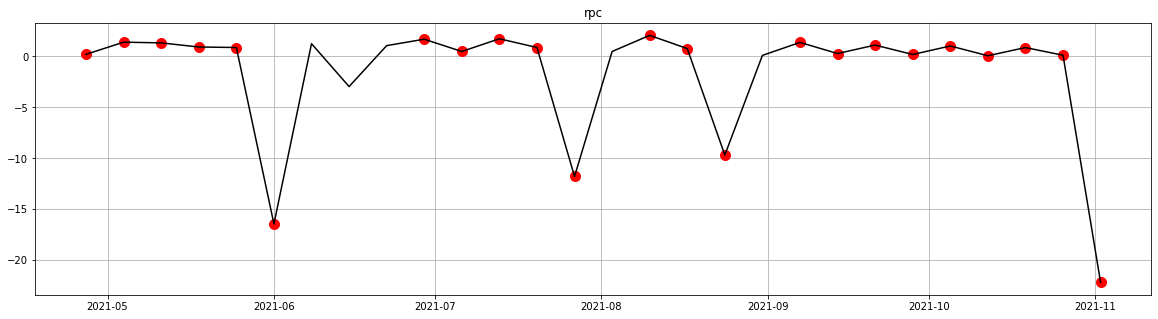

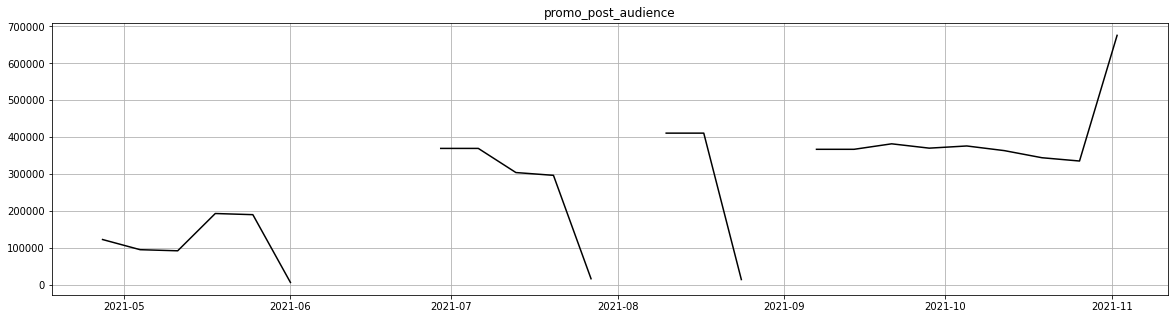

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


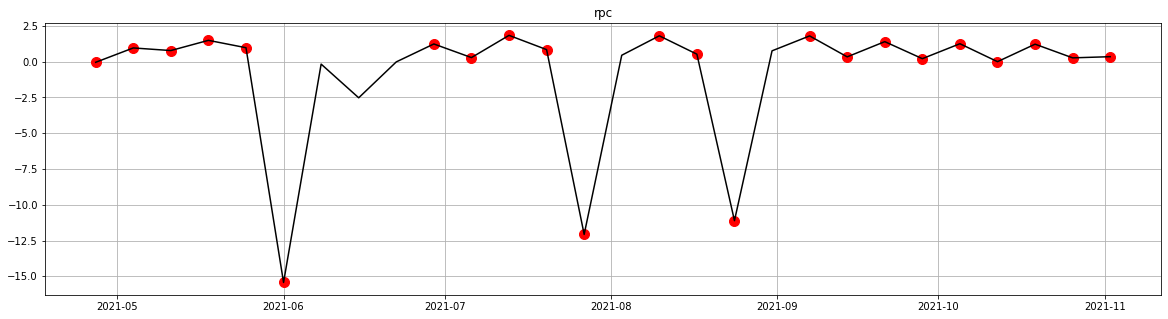

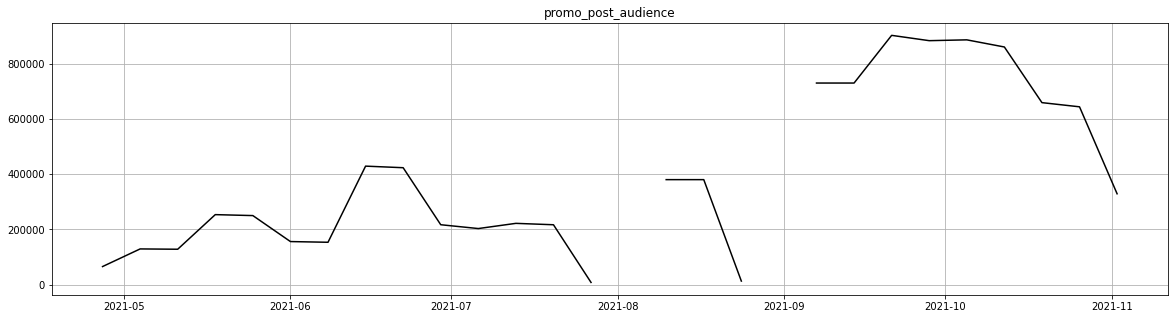

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


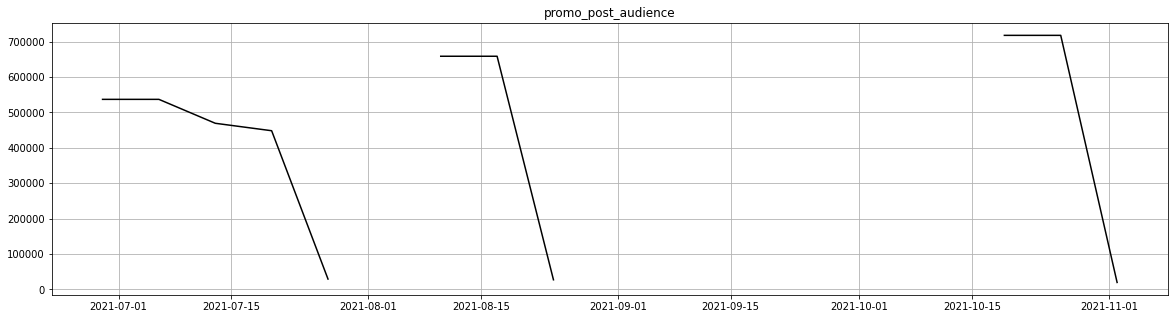

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.


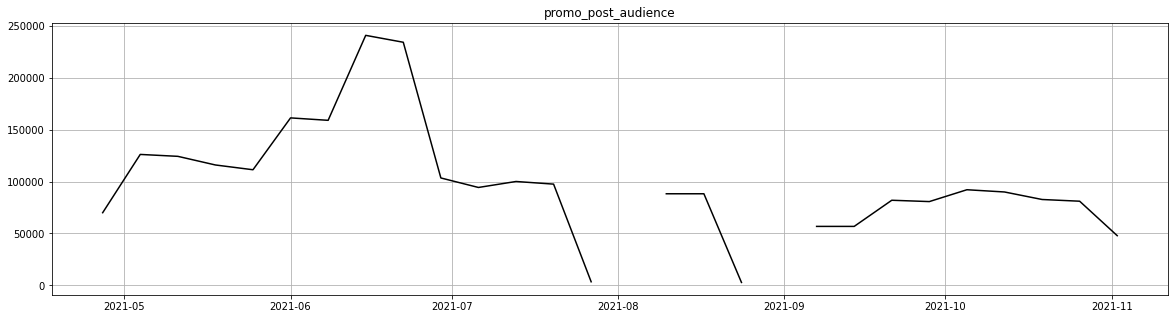

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


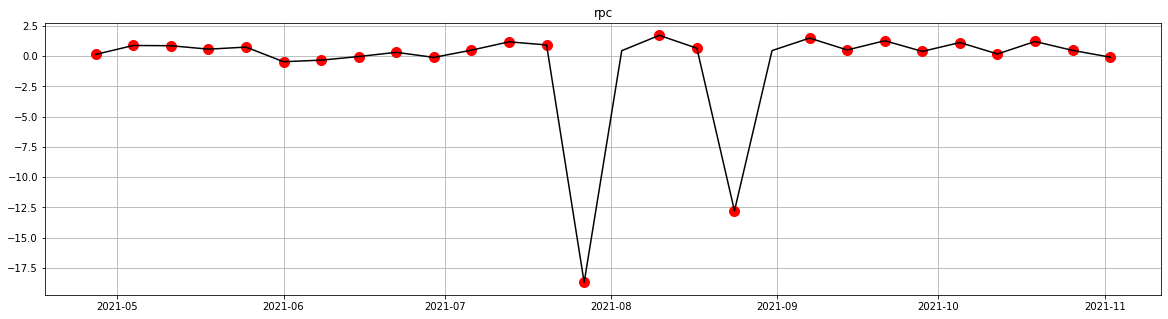

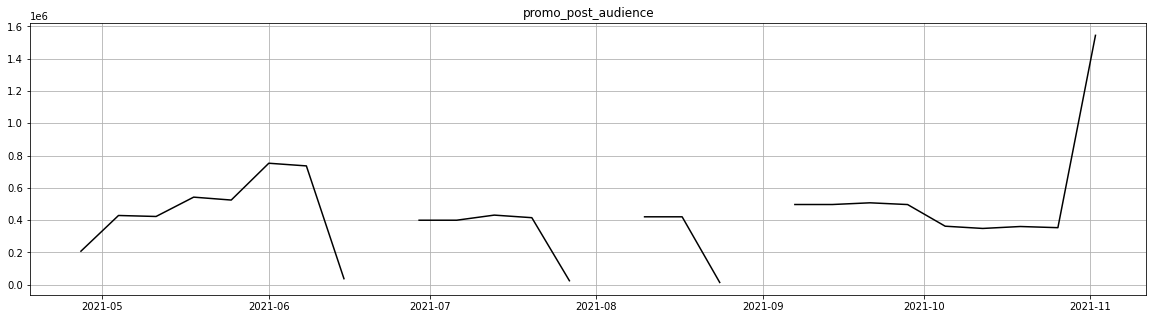

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


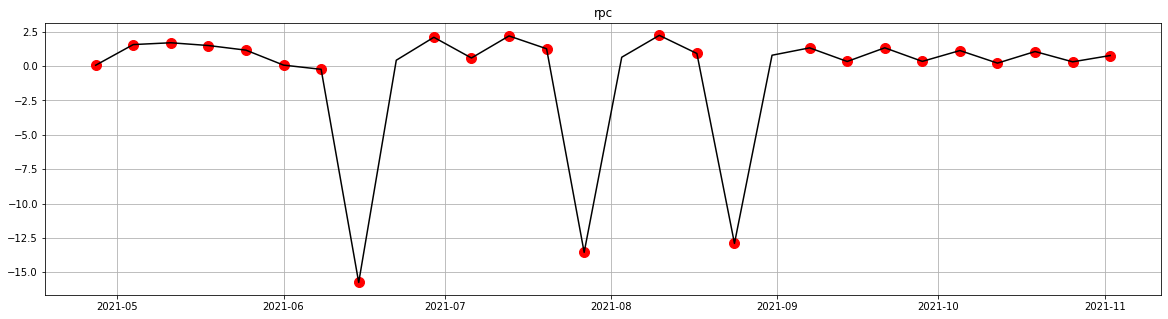

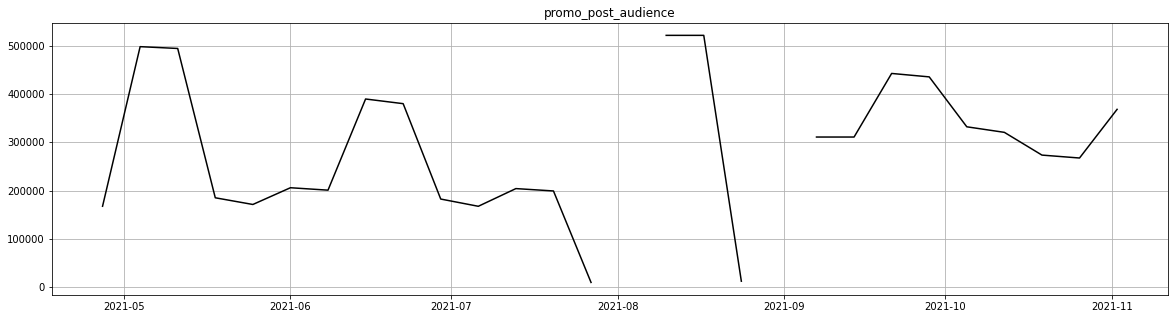

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


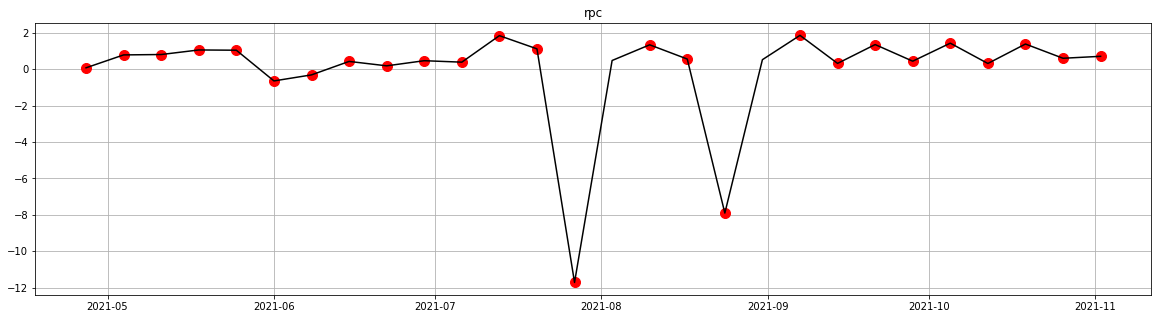

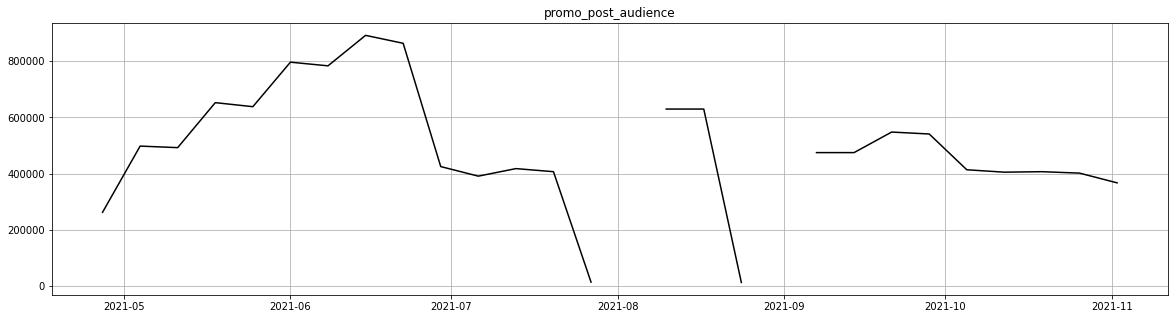

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


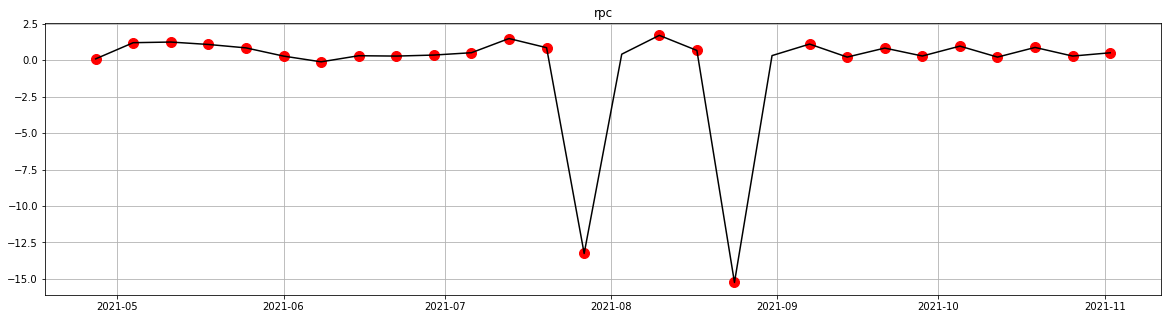

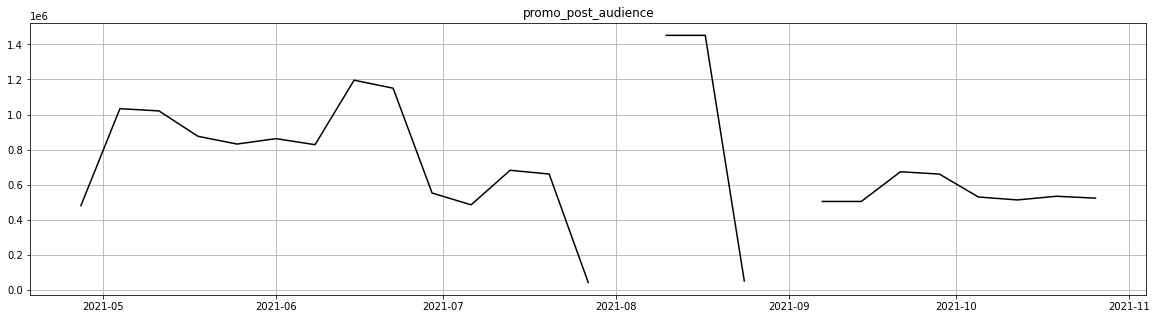

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


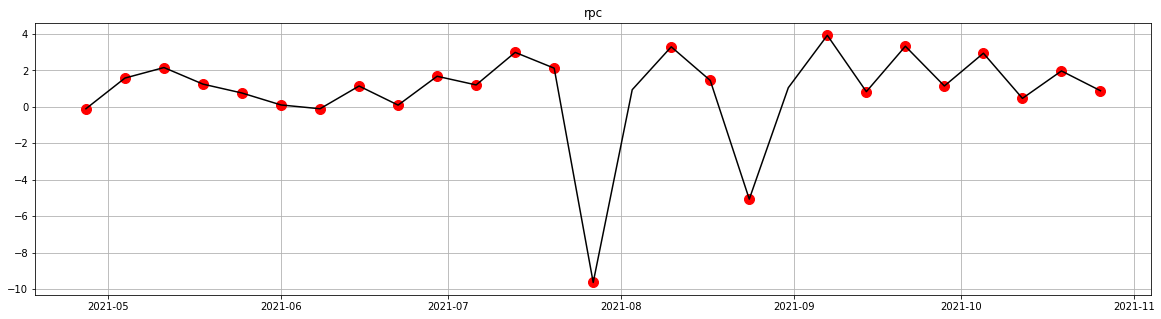

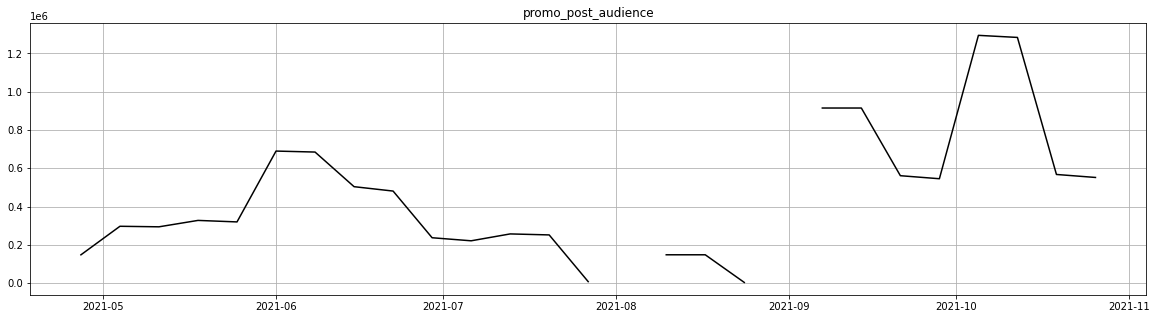

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


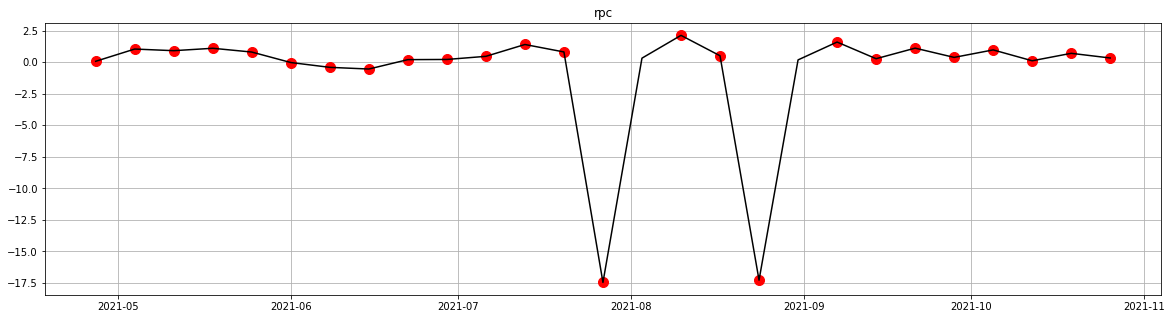

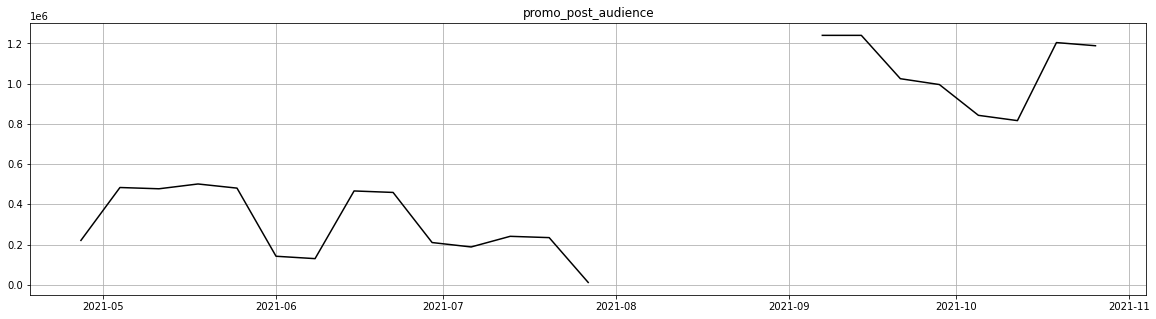

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.


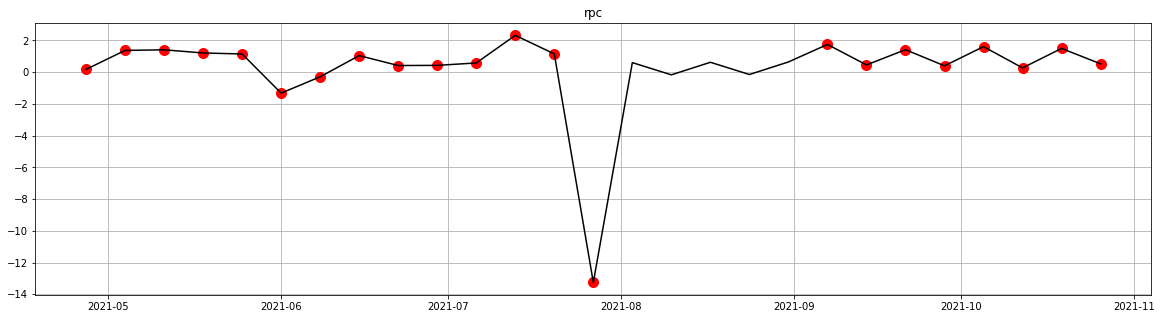

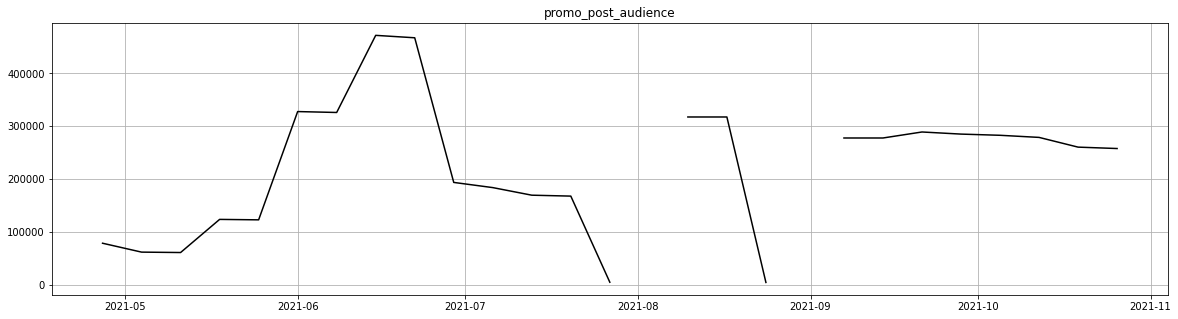

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


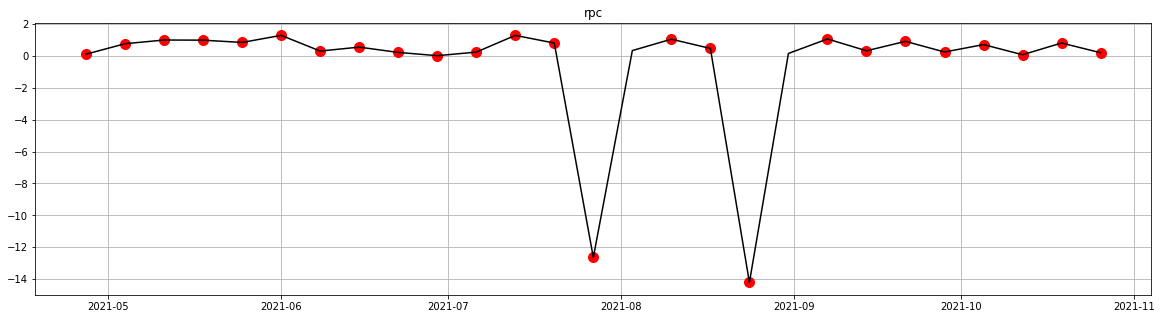

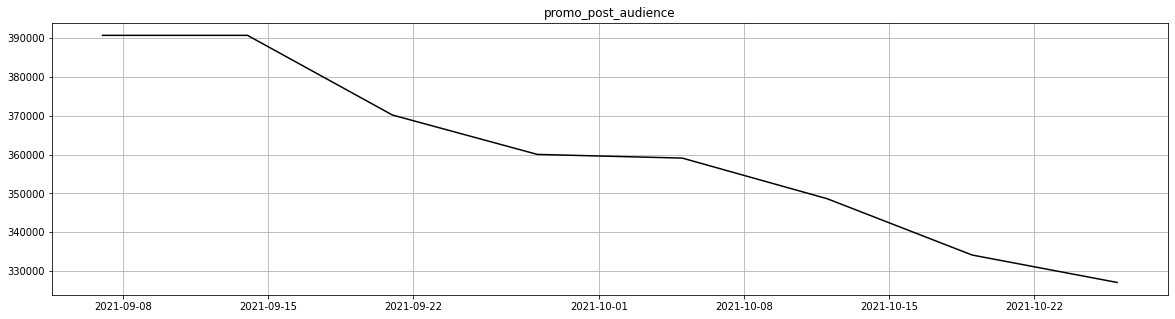

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.


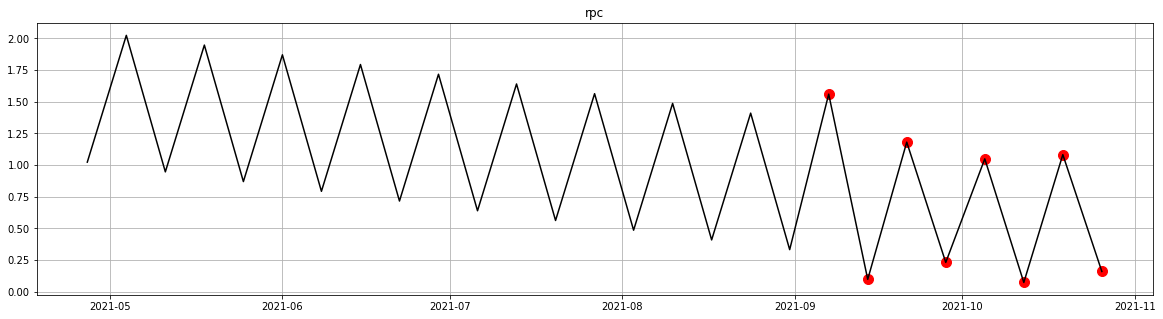

In [13]:
for offer_type in OFFER_TYPES:

    df = data.copy()[:-6]
    df = df[df['offer_type']==offer_type]
    df = df[['ds', SCALE, METRIC]]
    df.rename(columns={
        'ds': 'ds',
        METRIC: 'y',
        SCALE: 'scale'
    }, inplace=True)

    plt.figure(figsize=(20,5))
    plt.plot(df.ds, df.scale, 'k')
    plt.grid()
    plt.title(SCALE)
    plt.show()

    plt.figure(figsize=(20,5))
    plt.plot(df.ds, df.y, '.r', ms=20)

    df = prophet_impute(df)
    df = negative_impute(df)

    plt.plot(df.ds, df.y, 'k')
    plt.grid()
    plt.title(METRIC)
    plt.show()


### Training

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


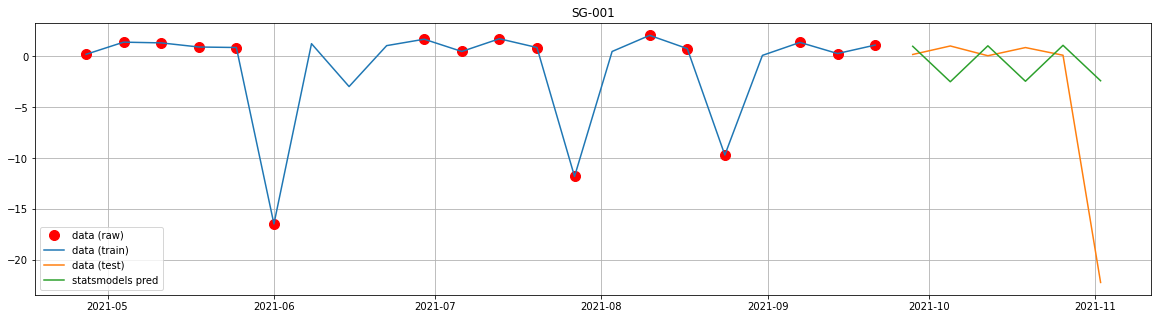

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


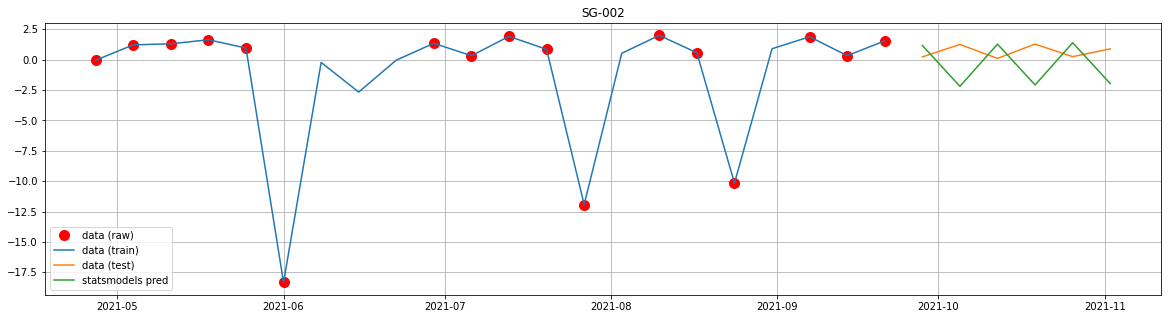

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


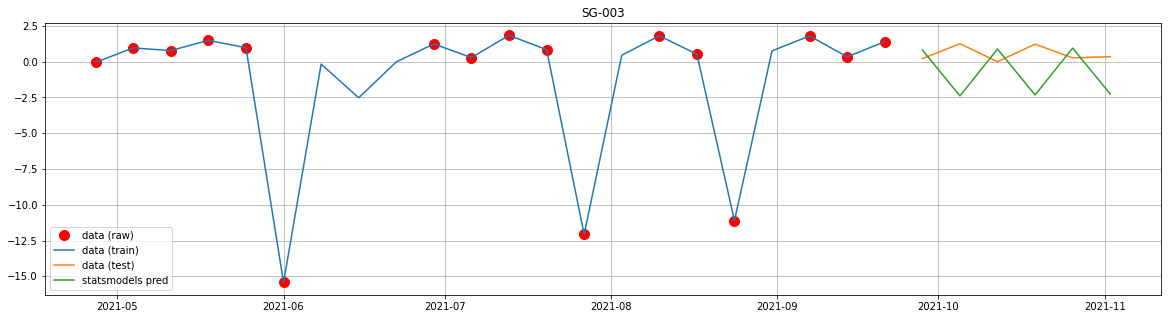

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


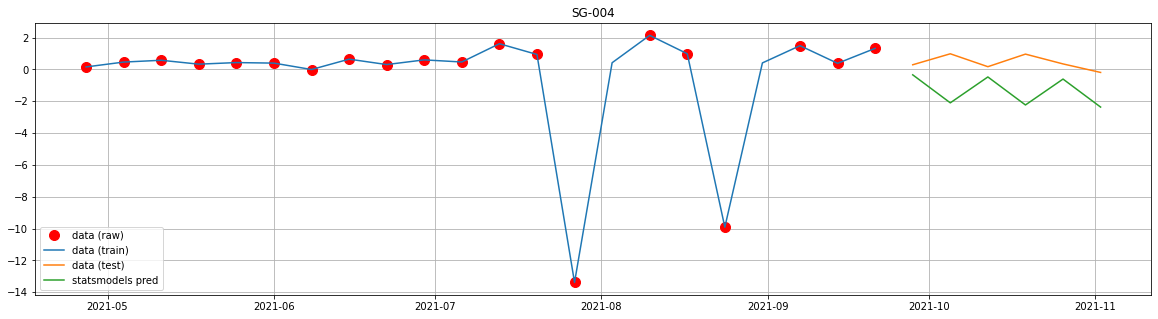

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.


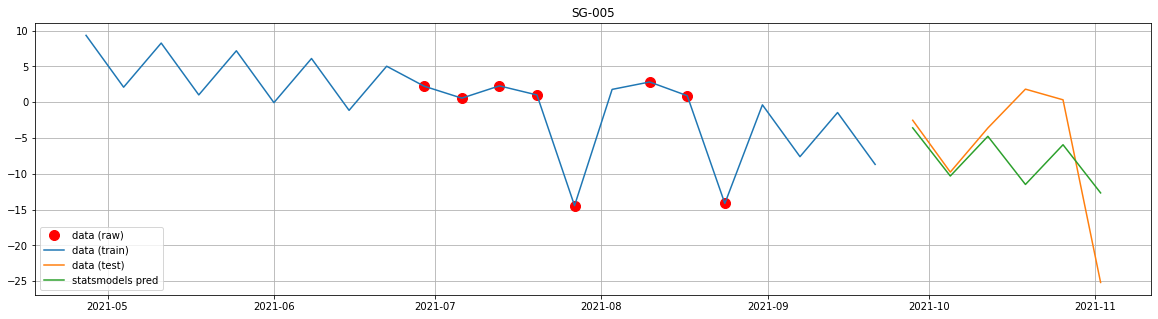

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


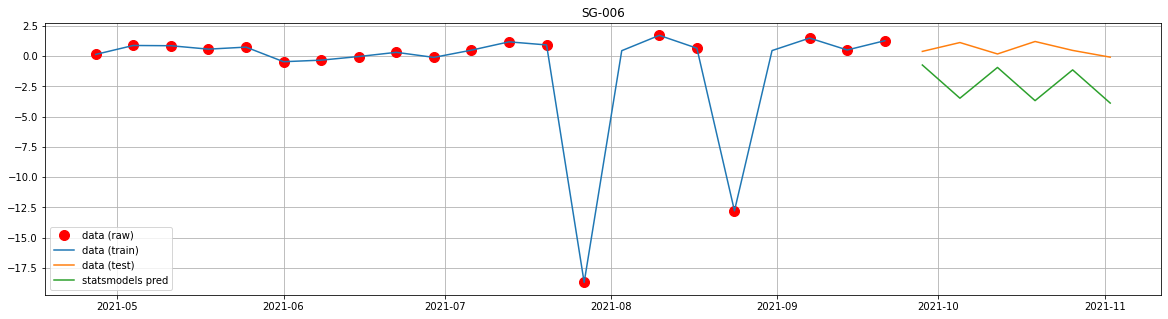

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


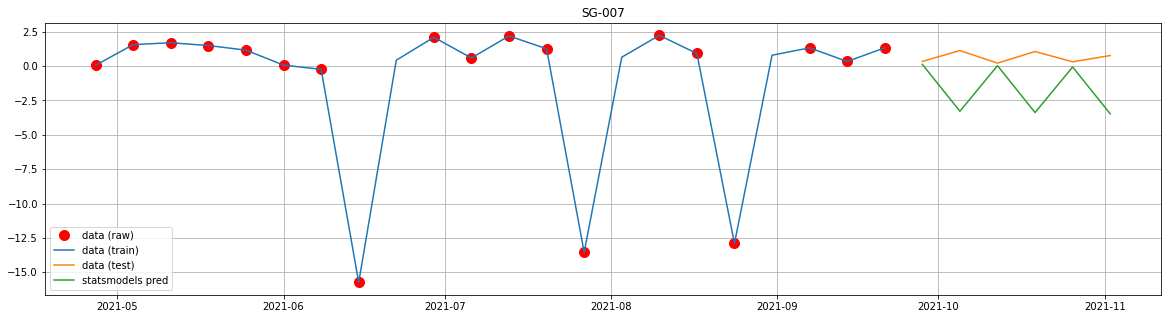

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


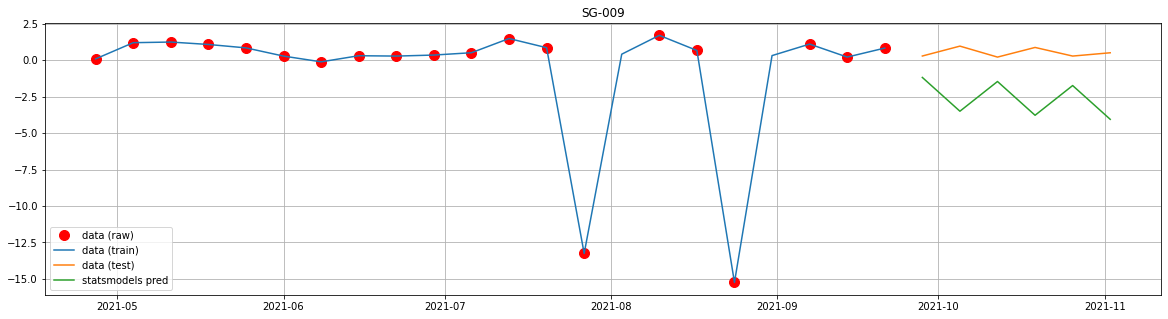

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


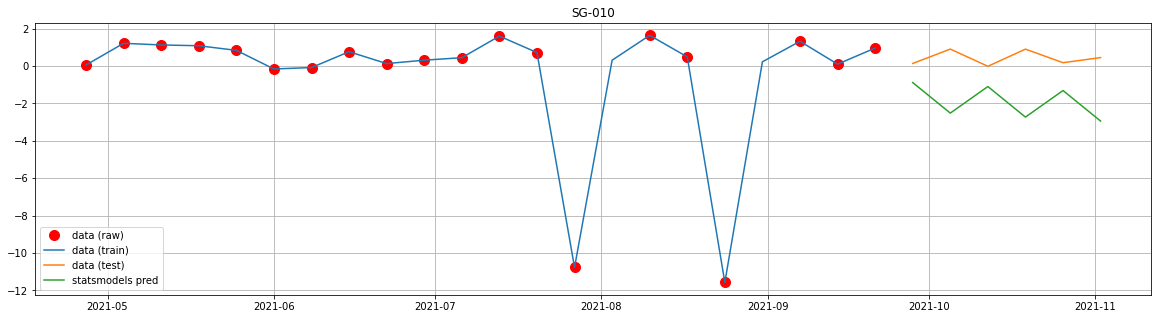

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


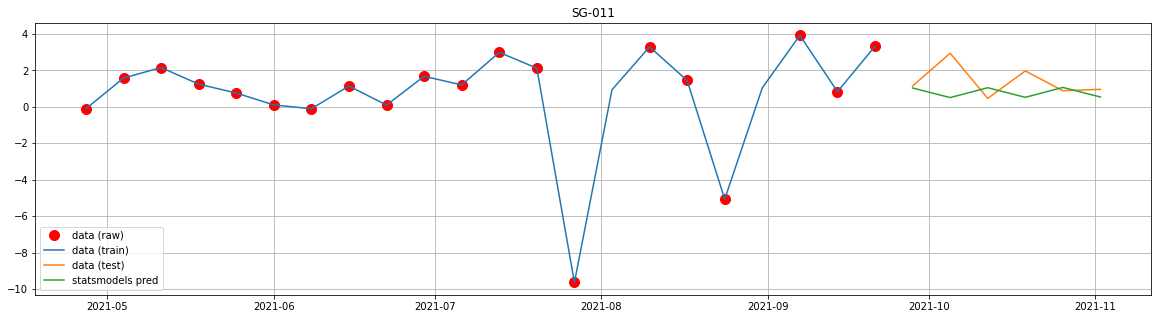

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


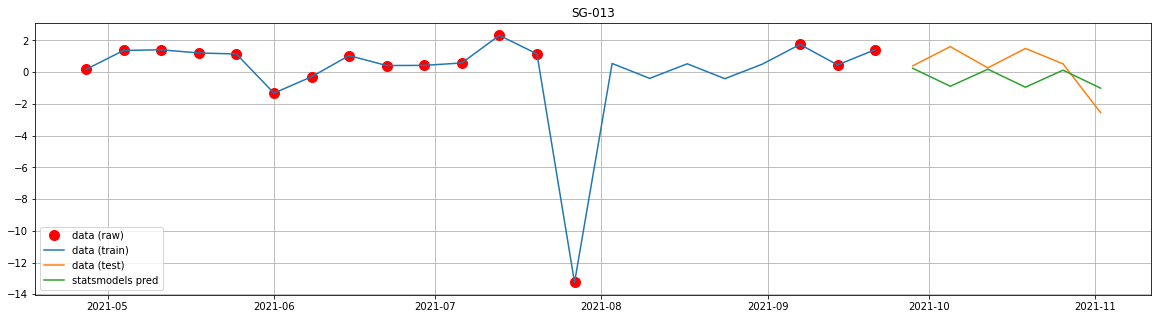

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.


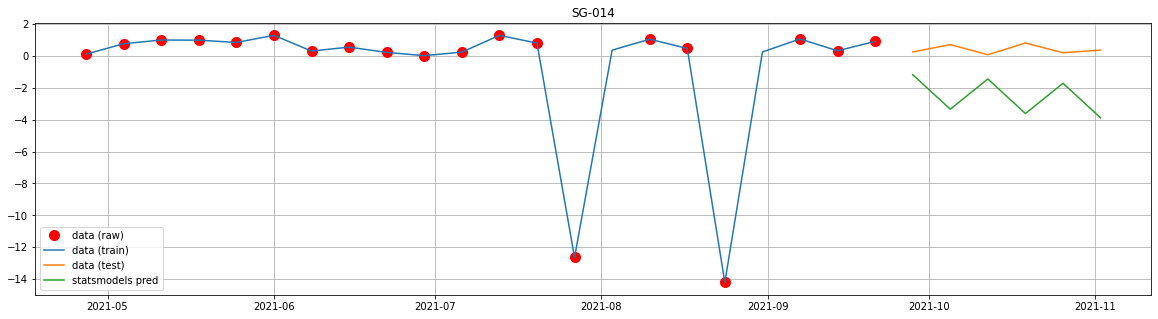

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.


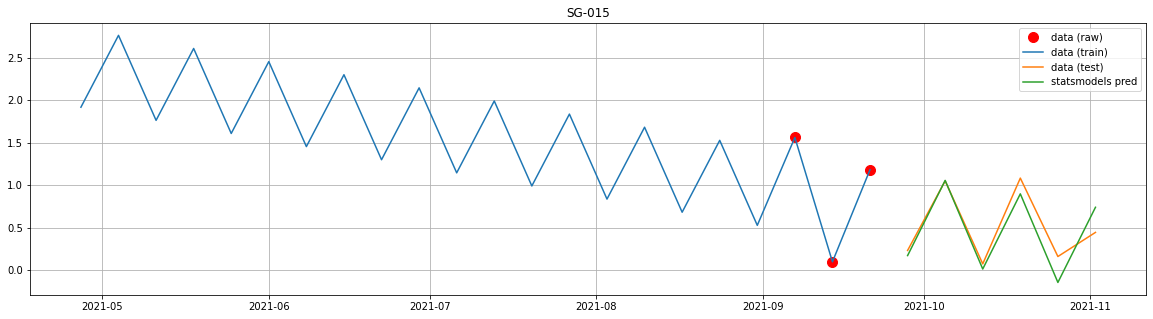

In [16]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

for offer_type in OFFER_TYPES:
    
    df = data.copy()
    df = df[df['offer_type']==offer_type]
    df = df[['ds', SCALE, METRIC]]
    df.rename(columns={
        'ds': 'ds',
        METRIC: 'y',
        SCALE: 'scale'
    }, inplace=True)
    
    plt.figure(figsize=(20,5))
    plt.title(f'{offer_type}')
    plt.plot(df.ds[:-WINDOW], df.y[:-WINDOW], '.r', ms=20, label='data (raw)')
    
    df = prophet_impute(df)
    df = negative_impute(df)

    model = ETSModel(
        df.y[:-WINDOW],
        error="add",
        trend="add",
        seasonal="add",
        seasonal_periods=2,
        initialization_method="estimated"
    )

    model_fit = model.fit(disp=0)
    pred = model_fit.get_prediction(start=len(df.y)-WINDOW, end=len(df.y)-1)
    pi = pred.summary_frame(alpha=0.05)

    # Post process
    if METRIC in ['rdm', 'cpc']:
        pi['mean'] = pi['mean'].apply(lambda x: 0 if x < 0 else x) 
        pi['pi_upper'] = pi['pi_upper'].apply(lambda x: 0 if x < 0 else x) 
        pi['pi_lower'] = pi['pi_lower'].apply(lambda x: 0 if x < 0 else x) 
        
    plt.plot(df.ds[:-WINDOW], df.y[:-WINDOW], label='data (train)')
    plt.plot(df.ds[-WINDOW:], df.y[-WINDOW:], label='data (test)')
    plt.plot(df.ds[-WINDOW:], pi['mean'], label='statsmodels pred')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# coeff = [ 1.0** i for i in range(12)]
# def forecast_next(u, coeff):
#     y = [coeff[i]**i*u[-2*(i+1)] for i in range(len(coeff))]
#     return np.sum(y) / np.sum(coeff)

# output = list(df.y[:-WINDOW])
# for i in range(WINDOW):
#     next_y = forecast_next(output, coeff)

#     if (METRIC in ['rdm', 'cpc']) and (next_y < 0):
#         output.append(0)
#     else:
#         output.append(next_y)

# plt.figure(figsize=(20,5))
# plt.plot(df.ds[:-WINDOW], df.y[:-WINDOW], label='data (train)')
# plt.plot(df.ds[-WINDOW:], df.y[-WINDOW:], label='data (test)')
# plt.plot(df.ds[-WINDOW:], output[-WINDOW:], label='pred')
# plt.legend()
# plt.show()

In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# model=SARIMAX(
#     df.y[:-WINDOW],
#     order=(1, 1, 1),
#     seasonal_order=(1, 1, 1, 2)
# )
# results=model.fit()

# plt.figure(figsize=(20,5))
# plt.plot(df.ds[:-WINDOW], df.y[:-WINDOW], label='data (train)')
# plt.plot(df.ds[-WINDOW:], df.y[-WINDOW:], label='data (test)')
# plt.plot(df.ds[-WINDOW:], results.predict(start=len(df.y)-WINDOW, end=len(df.y)-1), label='data (train)')
# plt.show()

In [ ]:
# import pmdarima as pm

# model = pm.auto_arima(
#     df.y[:-WINDOW], 
#     start_p=1,
#     start_q=1,
#     start_P=0,
#     m=2, 
#     seasonal=True)

# plt.figure(figsize=(20,5))
# plt.plot(df.ds[:-WINDOW], df.y[:-WINDOW], label='data (train)')
# plt.plot(df.ds[-WINDOW:], df.y[-WINDOW:], label='data (test)')
# plt.plot(df.ds[-WINDOW:], model.predict(6), label='meh')
# plt.show()